## Load Packages

In [1]:
using Dates        

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [3]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# The Binomial Model for One Time Interval

In a binomial model the underlying can change from $S$ today to either $Su$ or $Sd$ in the next period (which is $h$ years from now).

Let $f_u$ and $f_d$ be the value of the derivative in the up- and down-state next period. Then, the value today is

$f  =e^{-yh}\left[  pf_{u}+\left(  1-p\right)  f_{d}\right] \: \text{ with } \: p=\frac{e^{yh}-d}{u-d}$

For a call option, the payoffs in the two states are

$
f_u = \max(Su-K,0)
$

$
f_d = \max(Sd-K,0)
$

In [4]:
S = 10                          #underlying price today
u = 1.1                         
d = 0.95
K = 10                          #strike price: try different values
y = 0                           #interest rate
h = 1/12                        #time to expiration

fu = max(S*u-K,0)               #value of call option in up node 
fd = max(S*d-K,0)               #in down node
printlnPs("Payoffs in (u,d) at expiration of call option with strike $K: ",[fu fd])

p = (exp(y*h) - d)/(u-d)
printlnPs("\nRisk-neutral probability of up: ",p)

C = exp(-y*h)*(p*fu+(1-p)*fd)
printlnPs("\nPrice of call option with strike $K: ",C)

Payoffs in (u,d) at expiration of call option with strike 10:      1.000     0.000

Risk-neutral probability of up:      0.333

Price of call option with strike 10:      0.333


# A CRR Tree for Many Short Time Intervals

The CRR approach to construct $(u,d)$ for a small time step of length $h$ is 

$u=e^{\sigma\sqrt{h}} \: \text{ and }\: d=e^{-\sigma\sqrt{h}}$,

where $\sigma$ is the annualized standard deviation of the underlying.

In [5]:
m = 0.5                 #time to experiation (in years)                
y = 0.05                #interest rate (annualized) 

σ = 0.2                 #annualized std of underlying asset
n = 50                  #number of time steps of size h 
h = m/n                 #time step size (in years)

u = exp(σ*sqrt(h))
d = exp(-σ*sqrt(h))
p = (exp(y*h) - d)/(u-d)

printlnPs("(u,exp(yh),d,p) when σ=$σ and h=$h: ",[u exp(y*h) d p])

printlnPs("\nChecking if u > safe gross return > d: ",u > exp(y*h) > d)

(u,exp(yh),d,p) when σ=0.2 and h=0.01:      1.020     1.001     0.980     0.508

Checking if u > safe gross return > d:       true


## Build a Tree for the Underlying Asset

We create a tree by starting at the current spot price $S$. The future nodes are then created by multiplying by $u$ or $d$

$\text{step 0}: (S)$

$\text{step 1}: (Su,Sd)$

$\text{step 2}: (Suu,Sud,Sdd)$ (since $Sud=Sdu$)

...

Clearly, the vectors of nodes are of different lengths at the different steps (intervals).

The next cell illustrates how we can create a vector of vectors of different lengths: ```x[1]``` will be a vector ```[1]```, while ```x[2]``` will be a vector ```[2;2]```, etc. 

In [6]:
x = [ones(i)*i for i = 1:3]      #vector or vectors (of different lenghts)
for i = 1:length(x)
    printmat(x[i])
end

     1.000

     2.000
     2.000

     3.000
     3.000
     3.000



In [7]:
function BuildSTree(S,n,u,d)
    STree = [fill(NaN,i) for i = 1:n+1]  #vector of vectors (of different lengths)
    STree[1][1] = S                      #time node 1, element 1 
    for i = 2:n+1                        #move forward in time
        STree[i][1:end-1] = u*STree[i-1]   #up move from STree[i-1][1:end]
        STree[i][end] = d*STree[i-1][end]  #down move from STree[i-1][end] 
    end
    return STree    
end

BuildSTree (generic function with 1 method)

## Showing the Tree for the Underlying Asset

The next few cells illustrate how these nodes are put into an array of vectors and then shows the entire tree.

In [8]:
S = 42.0                             #current price of underlying asset

STree = BuildSTree(S,n,u,d)
println("printing the first 3 time steps in the tree")
for i = 1:3
    printmat(STree[i])
end 

println("\nNotice that the vectors are of different lengths")

printing the first 3 time steps in the tree
    42.000

    42.848
    41.168

    43.714
    42.000
    40.353


Notice that the vectors are of different lengths


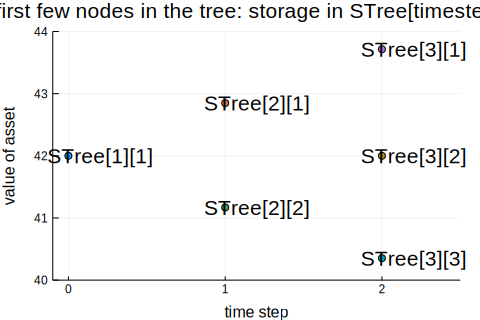

In [9]:
p1 = plot(legend=false,xlim=(-0.1,2.5),ylim=(40,44),xticks=0:2)
for i = 1:3, j = 1:length(STree[i])
    scatter!([i-1],[STree[i][j]])            #[] to make vectors
    annotate!(i-1+0.2,STree[i][j],"STree[$i][$j]")
end    
title!("The first few nodes in the tree: storage in STree[timestep][node]")
xlabel!("time step")
ylabel!("value of asset")

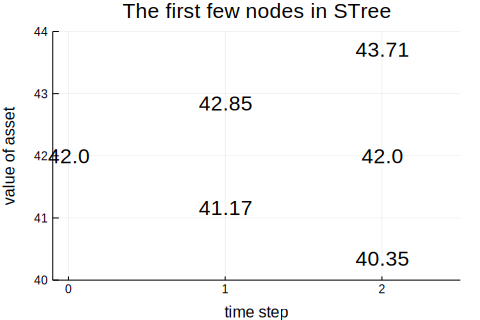

In [10]:
p1 = plot(legend=false,xlim=(-0.1,2.5),ylim=(40,44),xticks=0:2)
for i = 1:3, j = 1:length(STree[i])
    annotate!(i-1,STree[i][j],string(round(STree[i][j],digits=2,)))
end    
title!("The first few nodes in STree")
xlabel!("time step")
ylabel!("value of asset")

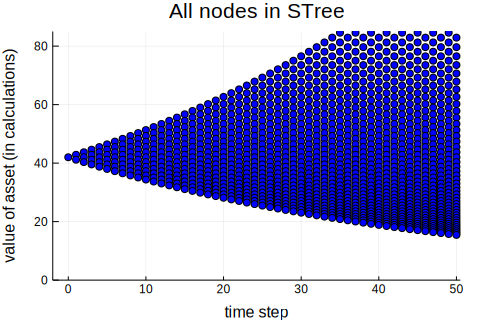

In [11]:
p1 = scatter([0.0],STree[1],color=:blue)
for i = 2:n+1
    scatter!(fill(i-1,i),STree[i],color=:blue)  
end
plot!(xlim=(-2,n+0.5),ylim=(0,85),legend=false,)
title!("All nodes in STree")
xlabel!("time step")
ylabel!("value of asset (in calculations)")

# Calculating the Option Price

Let $f_{ij}$ be the option price at time step $i$ when the underlying price is $S_{ij}$. (We use $S_{ij}$ as a shorthand notation, to avoid having to write things like $Sudd$.) In the code below, $S_{i1}$ is the highest node in time step $i$, $S_{i2}$ is the second highest, etc.

For a European call option, the call price at the last time step $n$ is 
$f_{nj} = \max(0,S_{nj}-K)$. 

Instead, the put price is 
$f_{nj} = \max(0,K-S_{nj})$. 

For all earlier time steps, the value is 

$f_{ij} = e^{-yh}[p f_{i+1,j} + (1-p) f_{i+1,j+1}]$

For instance,

$f_{i1} = e^{-yh}[p f_{i+1,1} + (1-p) f_{i+1,2}]$

$f_{i2} = e^{-yh}[p f_{i+1,2} + (1-p) f_{i+1,3}]$

### European Options

In [12]:
function EuOptionPrice(STree,K,y,n,h,u,d,p,isPut=false)     #price of European option
    Value = deepcopy(STree)                          #tree for derivative, to fill
    if isPut 
        Value[n+1] = max.(0,K.-STree[n+1])            #put, at last time node
    else
        Value[n+1] = max.(0,STree[n+1].-K)            #call, at last time node    
    end    
    for i = n:-1:1                                   #move backward in time
        Value[i] = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
    end                                           #p*up + (1-p)*down, discount   
    return Value
end

EuOptionPrice (generic function with 2 methods)

In [13]:
K = 42.0                                  #strike price 

Pe = EuOptionPrice(STree,K,y,n,h,u,d,p,true)        #Pe[1] is a 1x1 vector with the put price (node 0)
Ce = EuOptionPrice(STree,K,y,n,h,u,d,p,false)

Ce_parity = Pe[1][1] + S - exp(-m*y)*K              #put-call parity, Pe[1][1] is a scalar

printlnPs("European put and call prices at K=$K and S=$S: ",[Pe[1] Ce[1]])

printlnPs("\nCall price according to put-call partity:                    ",Ce_parity)

European put and call prices at K=42.0 and S=42.0:      1.844     2.881

Call price according to put-call partity:                         2.881


### American Options

The option values are calculated as for the European option, except that that the option value is 

$f_{ij} = \max(\text{value if exercised now},\text{continuation value})$

The *continuation value* has the same form (but possible different numbers) as in the European case. 

The *value of exercising now* is $S_{ij}-K$ for a call and $K-S_{ij}$ for a put.

In [14]:
function AmOptionPrice(STree,K,y,n,h,u,d,p,isPut=false)     #price of American option
    Value = deepcopy(STree)                          #tree for derivative, to fill
    if isPut 
        Value[n+1] = max.(0,K.-STree[n+1])            #put, at last time node
    else
        Value[n+1] = max.(0,STree[n+1].-K)            #call, at last time node    
    end    
    for i = n:-1:1                                   #move backward in time
        fa  = exp(-y*h)*(p*Value[i+1][1:end-1] + (1-p)*Value[i+1][2:end])
        if isPut 
            Value[i] = max.(K.-STree[i],fa)         #put
        else
            Value[i] = max.(STree[i].-K,fa)         #call       
        end    
    end
    return Value
end

AmOptionPrice (generic function with 2 methods)

In [15]:
K = 42.0                                  #strike price 

Pa = AmOptionPrice(STree,K,y,n,h,u,d,p,true)
Ca = AmOptionPrice(STree,K,y,n,h,u,d,p,false)

printlnPs("American put and call prices at K=$K and S=$S, ",[Pa[1] Ca[1]])

printlnPs("\nCompare with European put and call prices,         ",[Pe[1] Ce[1]])

println("\nInteresting exercise: change function to store also the nodes of early exercise---and then plot it")

American put and call prices at K=42.0 and S=42.0,      1.950     2.881

Compare with European put and call prices,              1.844     2.881

Interesting exercise: change function to store also the nodes of early exercise---and then plot it


## Plotting the Tree of the Options

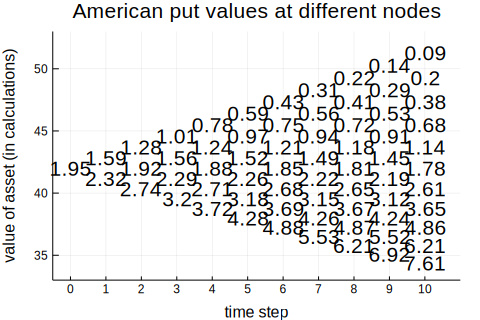

In [16]:
p1 = plot(xlim=(-0.5,11),ylim=(33,53),xticks=0:10,legend=false)
for i = 1:11, j = 1:length(STree[i])
    annotate!(i-1,STree[i][j],string(round(Pa[i][j],digits=2,)))
end    
plot!()
title!("American put values at different nodes")
xlabel!("time step")
ylabel!("value of asset (in calculations)")